# Load DeepFly3D Data

In [6]:
%load_ext autoreload
%autoreload 2
from load import *
import torch
import yaml
import logging
from imp import reload
import matplotlib.pyplot as plt
from liftpose.vision_3d import world_to_camera_dict
reload(logging)
logger = logging.getLogger(__name__).setLevel(logging.INFO)
from tqdm import tqdm
tqdm.get_lock().locks = []

# decleare data parameters
par_train = {  'data_dir'       : '/data/LiftPose3D/fly_tether/data_DF3D/', #mac/ubuntu path format
              #'data_dir'       : r'\Users\NeLy\Desktop\fly_tether', #windows path format
               'out_dir'        : '/data/LiftPose3D/fly_tether/fixed_cams/',
               'train_subjects' : [1,2,3,4,5],
               'test_subjects'  : [6,7],
               'actions'        : ['all'],
               'cam_id'         : [1,5]}

# merge with training parameters
par_data = yaml.full_load(open('param.yaml', "rb"))
par = {**par_data["data"], **par_train}

# Load 2D data
train_2d = load_2D(
    par["data_dir"],
    par,
    cam_id=par["cam_id"],
    subjects=par["train_subjects"],
    actions=par["actions"],
)
test_2d = load_2D(
    par["data_dir"],
    par,
    cam_id=par["cam_id"],
    subjects=par["test_subjects"],
    actions=par["actions"],
)

# Load 3D data
train_3d, train_keypts, rcams_train = load_3D(
    par["data_dir"],
    par,
    cam_id=par["cam_id"],
    subjects=par["train_subjects"],
    actions=par["actions"],
)
test_3d, test_keypts, rcams_test = load_3D(
    par["data_dir"],
    par,
    cam_id=par["cam_id"],
    subjects=par["test_subjects"],
    actions=par["actions"],
)

train_3d = world_to_camera_dict(train_3d, rcams_train)
test_3d = world_to_camera_dict(test_3d, rcams_test)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Train LiftPose3D Network on DeepFly3D Data

In [7]:
from liftpose.main import train as lp3d_train
from liftpose.lifter.augmentation import add_noise

lp3d_train(train_2d=train_2d, test_2d=test_2d,
           train_3d=train_3d, test_3d=test_3d, 
           train_keypts=train_keypts,
           test_keypts=test_keypts,
           roots=par['roots'],
           target_sets=par['target_sets'],
           out_dir=par['out_dir'],
           training_kwargs={"epochs":20},
          )#augmentation=[add_noise(noise_amplitude=.1)])

[main.py:190]:INFO:Saving pre-processed 2D data at /data/LiftPose3D/fly_tether/fixed_cams/stat_2d.pth.tar.
[main.py:209]:INFO:Saving pre-processed 3D data at /data/LiftPose3D/fly_tether/fixed_cams/stat_3d.pth.tar.
[main.py:237]:INFO:Starting training model.
[main.py:248]:DEBUG:
==================Options=================
[main.py:249]:DEBUG:{   'batch_size': 64,
    'data_dir': '/data/LiftPose3D/fly_tether/fixed_cams',
    'drop_input': 0.0,
    'dropout': 0.5,
    'epochs': 20,
    'exp': '',
    'is_train': True,
    'job': 8,
    'linear_size': 1024,
    'load': None,
    'lr': 0.001,
    'lr_decay': 5000,
    'lr_gamma': 0.9,
    'max_norm': True,
    'noise': None,
    'num_stage': 2,
    'out': '/data/LiftPose3D/fly_tether/fixed_cams',
    'out_dir': '/data/LiftPose3D/fly_tether/fixed_cams',
    'predict': False,
    'procrustes': False,
    'resume': False,
    'test': False}
[main.py:250]:DEBUG:==========================================

[lift.py:44]:INFO:Training on the device:

Epoch 000 | LR  0.00081 | Loss Test  0.00000 | Loss Train  0.13359|: 100%|██████████| 11051/11051 [01:04<00:00, 171.35it/s]
Epoch 001 | LR  0.00066 | Loss Test  0.07741 | Loss Train  0.10249|: 100%|██████████| 11051/11051 [01:04<00:00, 170.36it/s]
Epoch 002 | LR  0.00053 | Loss Test  0.07044 | Loss Train  0.09752|: 100%|██████████| 11051/11051 [01:04<00:00, 171.88it/s]
Epoch 003 | LR  0.00043 | Loss Test  0.06749 | Loss Train  0.09479|: 100%|██████████| 11051/11051 [01:05<00:00, 169.53it/s]
Epoch 004 | LR  0.00031 | Loss Test  0.06528 | Loss Train  0.09298|: 100%|██████████| 11051/11051 [01:06<00:00, 167.03it/s]
Epoch 005 | LR  0.00025 | Loss Test  0.06414 | Loss Train  0.09166|: 100%|██████████| 11051/11051 [01:04<00:00, 172.15it/s]
Epoch 006 | LR  0.00021 | Loss Test  0.06325 | Loss Train  0.09073|: 100%|██████████| 11051/11051 [01:17<00:00, 143.46it/s]
Epoch 007 | LR  0.00017 | Loss Test  0.06192 | Loss Train  0.08996|: 100%|██████████| 11051/11051 [01:04<00:00, 171.64it/s]
Epoch 00

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


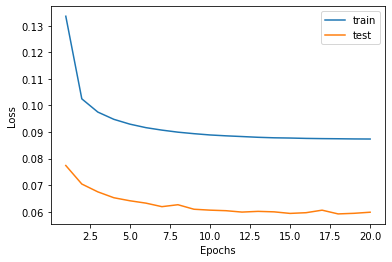

In [8]:
%matplotlib inline
from liftpose.plot import read_log_train, plot_log_train
epoch, lr, loss_train, loss_test = read_log_train(par['out_dir'])
plot_log_train(plt.gca(), loss_train, loss_test, epoch)
#plt.savefig('loss.svg')

# Run Trained LiftPose3D Network on the Test Data

In [36]:
from liftpose.postprocess import load_test_results
from liftpose.preprocess import concat_dict
from liftpose.vision_3d import camera_to_world, project_to_eangle
from liftpose.main import set_test_data
from liftpose.main import test as lp3d_test
from liftpose.lifter.utils import filter_data

test_3d_gt, test_3d_pred, good_keypts = [], [], []
for cam in par["cam_id"]:
    
    #load test data
    test_2d = load_2D(par["data_dir"],par,cam_id=[cam],subjects=par["test_subjects"],actions=par["actions"])
    test_3d, kp, rcams_test = load_3D(par["data_dir"],par,cam_id=[cam],subjects=par["test_subjects"],actions=par["actions"])
    test_3d = world_to_camera_dict(test_3d, rcams_test)
    
    #normalize test data
    test_2d, test_3d, stat_2d, stat_3d = set_test_data(par['out_dir'], test_2d, test_3d, kp.copy())
    
    #test data on network
    lp3d_test(par["out_dir"],test_2d, test_3d, kp.copy())
    
    #load statistics and test results
    gt, pred, _ = load_test_results(par['out_dir'], stat_2d, stat_3d)
    
    #transform back to world coordinates
    R = list(rcams_test.values())[0]['R']
    tvec = list(rcams_test.values())[0]['tvec']
    pred = camera_to_world(pred, R, tvec)
    gt = camera_to_world(gt, R, tvec)
    
    kp = concat_dict(kp)
    gt[~kp] = 0
    pred[~kp] = 0
    
    test_3d_gt.append(gt)
    test_3d_pred.append(pred)
    good_keypts.append(kp)
    
test_3d_gt = test_3d_gt[0] + test_3d_gt[1]
test_3d_pred = test_3d_pred[0] + test_3d_pred[1]
good_keypts = good_keypts[0] + good_keypts[1]

#filter noise
test_3d_gt = filter_data(test_3d_gt)
test_3d_pred = filter_data(test_3d_pred)

#rotate for easier visualisation
test_3d_gt = project_to_eangle(test_3d_gt, [-90,0,0], 'xyz')
test_3d_pred = project_to_eangle(test_3d_pred, [-90,0,0], 'xyz')


[main.py:386]:INFO:starting testing in path: /data/LiftPose3D/fly_tether/fixed_cams/
[lift.py:44]:INFO:Training on the device: cuda:0
[lift.py:71]:INFO:total params: 4.33M
[lift.py:79]:INFO:loading ckpt from '/data/LiftPose3D/fly_tether/fixed_cams/ckpt_best.pth.tar'
[lift.py:87]:INFO:ckpt loaded (epoch: 18 | err: 0.05912625673696869)
[lift.py:118]:INFO:Saving results: /data/LiftPose3D/fly_tether/fixed_cams/test_results.pth.tar
[main.py:386]:INFO:starting testing in path: /data/LiftPose3D/fly_tether/fixed_cams/
[lift.py:44]:INFO:Training on the device: cuda:0
[lift.py:71]:INFO:total params: 4.33M
[lift.py:79]:INFO:loading ckpt from '/data/LiftPose3D/fly_tether/fixed_cams/ckpt_best.pth.tar'
[lift.py:87]:INFO:ckpt loaded (epoch: 18 | err: 0.05912625673696869)
[lift.py:118]:INFO:Saving results: /data/LiftPose3D/fly_tether/fixed_cams/test_results.pth.tar


# Visualize Predictions

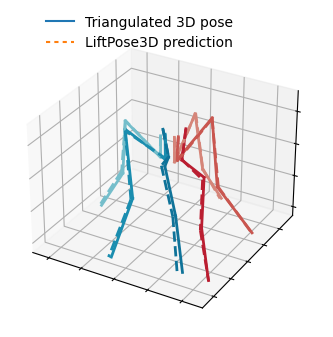

In [17]:
# conda install ipympl
%matplotlib inline
from liftpose.plot import plot_pose_3d
from scipy.spatial.transform import Rotation as Rot

t = 0

fig = plt.figure(figsize=plt.figaspect(1), dpi=100)
ax = fig.add_subplot(111, projection='3d')

plot_pose_3d(ax=ax, 
             bones=par_data["vis"]["bones"],
             pred=test_3d_pred[t],
             tar=test_3d_gt[t],
             limb_id=par_data["vis"]["limb_id"], 
             colors=par_data["vis"]["colors"],
             legend=True)

# Video

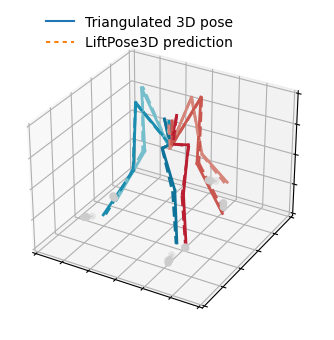

In [28]:
from liftpose.plot import plot_video_3d

fig = plt.figure(figsize=plt.figaspect(1), dpi=100)
ax = fig.add_subplot(111, projection='3d')

ax.set_xlim([-4,2])
ax.set_ylim([-3,2])
ax.set_zlim([0,2])
    
plot_video_3d(fig, ax, n=900, par=par_data, tar=test_3d_gt, pred=test_3d_pred, trailing=10, trailing_keypts=[4,9,14,19,24,29], fps=20)

# Errors

[utils.py:145]:INFO:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[utils.py:157]:INFO:NumExpr defaulting to 8 threads.


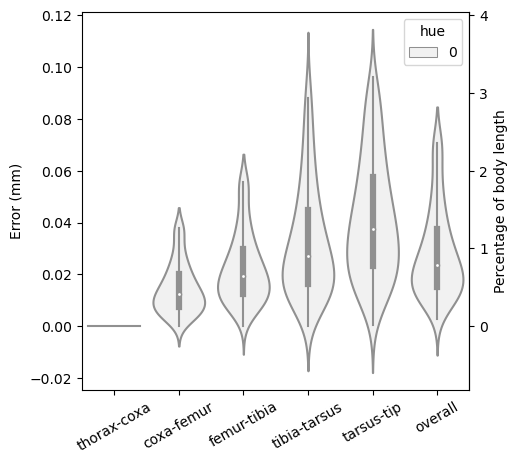

In [37]:
%matplotlib inline
from liftpose.plot import violin_plot
import random, string
plt.figure(figsize=(5,5), dpi=100)
names = ['thorax-coxa','coxa-femur','femur-tibia','tibia-tarsus','tarsus-tip']
ax = plt.gca()
s = test_3d_gt.shape
test_3d_gt_reshape = test_3d_gt.reshape(s[0]*6, s[1]//6, 3)
test_3d_pred_reshape = test_3d_pred.reshape(s[0]*6, s[1]//6, 3)
violin_plot(ax, gt=test_3d_gt_reshape, pred=test_3d_pred_reshape, good_keypts=np.ones_like(test_3d_gt_reshape),
                name=names, order=names, units='mm', body_length=3)